## Introduction

MNIST is the "hello world" of image classification. It is a dataset of handwritten digits taken mostly from United States Census Bureau employees. It is a set of images of digits 0-9, in grayscale and exactly identical dimensions, 28pixels x 28pixels. This serves as a relatively simple test for machine learning experiments and evaluating different models.

In this notebook, I explore convolutional neural networks using Keras. Specifically, explore how techniques such as adaptive learning rate and data augmentation affect classification accuracy. While I expect to see fairly high accuracy, that is not the primary objective here.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
#print(check_output(["ls", "../input"]).decode("utf8"))

# Any results you write to the current directory are saved as output.

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import matplotlib
import matplotlib.image as mpimg
import numpy as np
from numpy import random

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from scipy.interpolate import interp1d, Rbf

def display_images(X, y, rows=5, columns=5, cmap="binary"):
    """ Display images and labels
    """
    fig, ax = plt.subplots(rows,columns, figsize=(6,6))
    for row in range(rows):
        for column in range(columns):
            ax[row][column].imshow(X[(row*columns)+column].reshape(28,28), cmap=cmap)
            ax[row][column].set_title("{}:{}".format("label",np.argmax(y[(row*columns)+column])))
            ax[row][column].set_axis_off()
    fig.tight_layout()

%matplotlib inline

Using TensorFlow backend.


## Load and prepare data
Our data is a csv file with the true classification in the ```label``` column, followed by 784 pixel values (28x28 pixels unrolled). Each pixel takes a value ranging from 0-255. Since these are black and white images, each pixel is represented by a single value (channel) instead of three separate R, G, B values (3 channels) in a color image. 

In [4]:
df = pd.read_csv("../input/train.csv")
df.sample(1)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
15592,2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


We randomly split this set of 42000 images into 3 sets - 
- training: data used to train convnet
- cross validation: data used to validate performance
- test: data used to test classification accuracy

Each of these sets consists of features (X_ numpy array) and a vector of output labels (y) 

While there is a separate test set available, we are not using that in this notebook, since it is not labeled and cannot be easily evaluated.


In [5]:
X_train, X_val, y_train, y_val = train_test_split(df.iloc[:,1:].values, df.iloc[:,0].values, test_size = 0.4)
X_cv, X_test, y_cv, y_test = train_test_split(X_val, y_val, test_size = 0.5)
print("X_train:{}\ny_train:{}\n\nX_cv:{}\ny_cv:{}\n\nX_test:{}\ny_test:{}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

X_train:(25200, 784)
y_train:(25200,)

X_cv:(8400, 784)
y_cv:(8400,)

X_test:(8400, 784)
y_test:(8400,)


This data is in an unrolled format, i.e. each sample is a sequence of 784 pixel values. We will convert this using numpy's reshape function to (28x28x1). i.e. an image that is 28 pixels wide and 28 pixels tall, with 1 channel (black and white image).  So for example, the shape of the training set becomes (25200 samples, 28px, 28px, 1ch)

We change the output class (label) to categorical (one hot format). i.e. instead of a single value 0-9, we convert this to a array of size 10 with the corresponding element turned on. e.g.

Output label y = [9] becomes

y = [0,0,0,0,0,0,0,0,1,0]

Additionally, we scale all the features (pixel values) from a range of 0-255, to a range of 0-1. This is done by dividing each value in the feature matrix by 255.

Here are the new shapes of training, cross validation and test data sets.

In [6]:
width = 28
height = 28
channels = 1
X_train = X_train.reshape(X_train.shape[0], width, height, channels)
X_cv = X_cv.reshape(X_cv.shape[0], width, height, channels)
X_test = X_test.reshape(X_test.shape[0], width, height, channels)

# convert output classes to one hot representation
y_train = np_utils.to_categorical(y_train, num_classes=10)
y_cv = np_utils.to_categorical(y_cv, num_classes=10)
y_test = np_utils.to_categorical(y_test, num_classes=10)

X_train = X_train.astype('float32')
X_cv = X_cv.astype('float32')
X_test = X_test.astype('float32')

# Scale features (pixel values) from 0-255, to 0-1 
X_train /= 255
X_cv /= 255
X_test /= 255
print("Reshaped:")
print("X_train:{}\ny_train:{}\n\nX_cv:{}\ny_cv:{}\n\nX_test:{}\ny_test:{}".format(X_train.shape, y_train.shape, X_cv.shape, y_cv.shape, X_test.shape, y_test.shape))

Reshaped:
X_train:(25200, 28, 28, 1)
y_train:(25200, 10)

X_cv:(8400, 28, 28, 1)
y_cv:(8400, 10)

X_test:(8400, 28, 28, 1)
y_test:(8400, 10)


And a preview of few images in the training set.

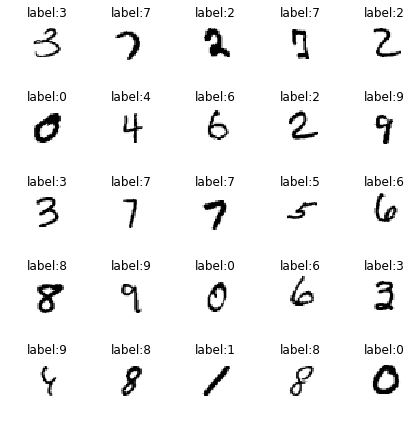

In [7]:
display_images(X_train, y_train)

Next, we will create two ConvNets using Keras sequential model - A small convnet with a very few layers, and a deeper convolutional network with many layers. We will then explore these models with and without adaptive learning rate and data augmentation.

In [9]:
batch_size=32
epochs=15

def small_cnn_model():
    m = Sequential()
    m.add(Conv2D(32, (5, 5), activation='relu', input_shape=(width, height, channels) ))
    m.add(MaxPooling2D(pool_size=(3,3)))
    m.add(Flatten())
    m.add(Dense(128, activation='relu'))
    m.add(Dropout(0.4))
    m.add(Dense(10, activation='softmax'))
    m.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    return m

def deep_cnn_model():
    m = Sequential()
    m.add(Conv2D(32, (5, 5), activation='relu', input_shape=(width, height, channels) ))
    m.add(Conv2D(32, (5,5)))
    m.add(MaxPooling2D(pool_size=(2,2)))
    m.add(Dropout(0.2))
    m.add(Conv2D(64, (3,3)))
    m.add(Conv2D(64, (3,3)))
    m.add(MaxPooling2D(pool_size=(2,2)))
    m.add(Dropout(0.2))
    m.add(Flatten())
    m.add(Dense(1024, activation='relu'))
    m.add(Dropout(0.4))
    m.add(Dense(10, activation='softmax'))
    m.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
    return m

def plot_metrics(h, title=""):
    """ Plot training metrics - loss and accuracy, for each epoch, 
        given a training history object
    """
    fig, axes = plt.subplots(1,2, figsize=(10,5))
      
    axes[0].plot(h.history['loss'], color="steelblue", label="Training", lw=2.0)
    axes[0].plot(h.history['val_loss'], color="orchid", label="Validation", lw=2.0)

    axes[0].set_title("{} (Loss)".format(title))
    axes[0].set_xlabel("Epoch")
    axes[0].set_ylabel("Loss")

    axes[1].plot(h.history['acc'], color="steelblue", label="Training", lw=2.0)
    axes[1].plot(h.history['val_acc'], color="orchid", label="Validation", lw=2.0)
    
    axes[1].set_title("{} (Accuracy)".format(title))
    axes[1].set_xlabel("Epoch")
    axes[1].set_ylabel("Accuracy")

    for axis in axes:
        axis.ticklabel_format(useOffset=False)
        axis.spines["top"].set_visible(False)
        axis.spines["right"].set_visible(False)
        axis.legend(loc='best', shadow=False)
    fig.tight_layout()

## Training a small convnet

Our small convnet with 1 convolutional layer and 2 dense layers, looks like this.

<img src="https://raw.githubusercontent.com/vinayshanbhag/keras-cnn-mnist/master/sm.png"/>

In [10]:
sm = small_cnn_model()
#sm.summary()
metrics_small = sm.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv,y_cv), verbose = 2, shuffle=True)
#sm.save_weights("small.h5")

Train on 25200 samples, validate on 8400 samples
Epoch 1/15
13s - loss: 0.3139 - acc: 0.9053 - val_loss: 0.1010 - val_acc: 0.9680
Epoch 2/15
12s - loss: 0.1155 - acc: 0.9660 - val_loss: 0.0690 - val_acc: 0.9779
Epoch 3/15
12s - loss: 0.0833 - acc: 0.9758 - val_loss: 0.0546 - val_acc: 0.9827
Epoch 4/15
12s - loss: 0.0674 - acc: 0.9790 - val_loss: 0.0506 - val_acc: 0.9861
Epoch 5/15
12s - loss: 0.0530 - acc: 0.9839 - val_loss: 0.0469 - val_acc: 0.9855
Epoch 6/15
12s - loss: 0.0500 - acc: 0.9833 - val_loss: 0.0428 - val_acc: 0.9870
Epoch 7/15
12s - loss: 0.0423 - acc: 0.9861 - val_loss: 0.0421 - val_acc: 0.9873
Epoch 8/15
12s - loss: 0.0344 - acc: 0.9885 - val_loss: 0.0461 - val_acc: 0.9855
Epoch 9/15
11s - loss: 0.0330 - acc: 0.9895 - val_loss: 0.0409 - val_acc: 0.9871
Epoch 10/15
11s - loss: 0.0275 - acc: 0.9909 - val_loss: 0.0477 - val_acc: 0.9861
Epoch 11/15
11s - loss: 0.0245 - acc: 0.9925 - val_loss: 0.0477 - val_acc: 0.9873
Epoch 12/15
11s - loss: 0.0244 - acc: 0.9917 - val_loss: 0

Loss and accuracy metrics by epoch for this small ConvNet

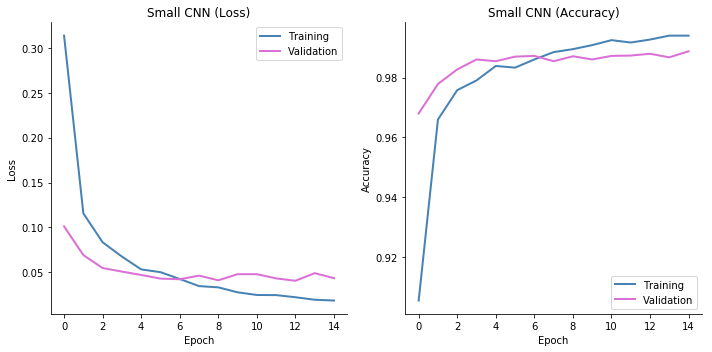

In [ ]:
plot_metrics(metrics_small,"Small CNN")

## Training a deep convnet
Our deep convnet with 4 convolutional layers and 2 dense layers, looks like this.

<img src="https://raw.githubusercontent.com/vinayshanbhag/keras-cnn-mnist/master/dm.png"/>

In [ ]:
dm = deep_cnn_model()
#dm.summary()
metrics_deep = dm.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv, y_cv), verbose = 2, shuffle=True)
#plot_model(dm, show_shapes=True, show_layer_names=False,to_file='dm.png')

Train on 25200 samples, validate on 8400 samples
Epoch 1/15
79s - loss: 0.2273 - acc: 0.9302 - val_loss: 0.0613 - val_acc: 0.9799
Epoch 2/15
79s - loss: 0.0868 - acc: 0.9739 - val_loss: 0.0554 - val_acc: 0.9831
Epoch 3/15
91s - loss: 0.0719 - acc: 0.9781 - val_loss: 0.0696 - val_acc: 0.9793
Epoch 4/15


Loss and Accuracy metrics for this model by epoch.

In [ ]:
#dm.save_weights("deep.h5")
plot_metrics(metrics_deep,"Deep CNN")

## Adaptive Learning Rate

Learning rate is the step size in gradient descent. Our convnet is trying to find the lowest point, the point at which the loss is minimum. If the step size is too large, it may not converge or take too long. On the other hand, if the step size is too small, it may converge on a local minimum.
<p>&nbsp;</p>
<sup style="float: left;">Source: Wikimedia Commons, the free media repository</sup>
<img style="float: left;" src="https://upload.wikimedia.org/wikipedia/commons/thumb/1/1e/Extrema_example.svg/300px-Extrema_example.svg.png"/>
<p style="float: left;">We will use ```ReduceLROnPlateau``` to adapt the learning rate based on results from each epoch. For instance, if the validation accuracy doesn't improve in 2 subsequent epochs (patience), then reduce the learning rate by half (factor).  See [```ReduceLROnPlateau```](https://keras.io/callbacks/#reducelronplateau) for more options.</p>

<p style="float: left">Further, the verbose mode, allows us to see when this happens.</p>

In [13]:
lrc = ReduceLROnPlateau(monitor='val_acc', patience=2, verbose=2, factor=0.5, cooldown=2, epsilon=0.00001)

## Training a small convnet with adaptive learning rate
Here we train the same small convnet we used earlier, but with adaptive learning rate. 

In [ ]:
smlrc = small_cnn_model()
metrics_small_lrc = smlrc.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv, y_cv), verbose = 2, shuffle=True, callbacks=[lrc])
#smlrc.save_weights("small_lrc.h5")

Loss and Accuracy metrics for this model with adaptive learning rate.

In [ ]:
plot_metrics(metrics_small_lrc, "Small CNN with \nAdaptive Learning Rate\n")

## Training a deep convnet with adaptive learning rate
Here we train the same deep convnet we used earlier, but with adaptive learning rate. 

In [ ]:
dmlrc = deep_cnn_model()
metrics_deep_lrc = dmlrc.fit(X_train, y_train, batch_size = batch_size, epochs = epochs, 
          validation_data = (X_cv, y_cv), verbose = 2, shuffle=True, callbacks=[lrc])
#dmlrc.save_weights("deep_lrc.h5")

Loss and accuracy metrics for this deep convnet with adaptive learning rate.

In [ ]:
plot_metrics(metrics_deep_lrc, "Deep CNN with Adaptive Learning Rate")

## Data Augmentation

To improve classification accuracy, we can augment the training samples, with random transformations of images in the training set. In Keras, this is done using ```keras.preprocessing.image.ImageDataGenerator``` class. We can apply random transformations such as, zooming, rotation, shifting the image up/down. We will limit rotation to a few degrees, and disable horizontal and vertical flipping, as our dataset of digits is prone to produce ambiguous results with these operations. 

See [```ImageDataGenerator```](https://keras.io/preprocessing/image/#imagedatagenerator) for lots of other options that are useful for other types of images.

In [ ]:
idg = ImageDataGenerator(
        rotation_range=15,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=False,
        vertical_flip=False, data_format="channels_last")

Here are a few images produced by the image data generator.

In [ ]:
image_data = idg.flow(X_train,y_train, batch_size=25).next()
print("Sample images from ImageDataGenerator:")
display_images(image_data[0], image_data[1])

## Training a small convnet with data augmentation

Here we train the same small convnet we used earlier, but with data augmentation and adaptive learning rate.. 

In [ ]:
smalrc = small_cnn_model()
metrics_small_lrc_augmented = smalrc.fit_generator(idg.flow(X_train,y_train, batch_size=batch_size),
                    epochs = epochs,
                    steps_per_epoch=X_train.shape[0]/10,
                    validation_data=(X_cv,y_cv),
                    callbacks=[lrc],
                    verbose = 2)
smalrc.save_weights("small_lrc_augmented.h5")

Loss and accuracy metrics for a small convnet with data augmentation and adaptive learning rate.

In [ ]:
plot_metrics(metrics_small_lrc_augmented, "Small CNN with \nAdaptive Learning Rate\n and Data Augmentation\n")

## Training a deep convnet with data augmentation

Next we train the same deep convnet we used earlier, but with data augmentation and adaptive learning rate. 

In [ ]:
dmalrc = deep_cnn_model()
metrics_deep_lrc_augmented = dmalrc.fit_generator(idg.flow(X_train,y_train, batch_size=batch_size),
                    epochs = epochs,
                    steps_per_epoch=X_train.shape[0]/10,
                    validation_data=(X_cv,y_cv),
                    callbacks=[lrc],                         
                    verbose = 2)
#dmalrc.save_weights("deep_lrc_augmented.h5")

Loss and accuracy metrics for a deep convnet with data augmentation and adaptive learning rate.

In [ ]:
plot_metrics(metrics_deep_lrc_augmented,"Deep CNN with \nAdaptive Learning Rate and \nData Augmentation\n")

## Validation Accuracy

How did the various models do in terms of validation accuracy?

In [ ]:
metrics = [metrics_small, metrics_small_lrc, metrics_small_lrc_augmented, metrics_deep, metrics_deep_lrc, metrics_deep_lrc_augmented]
models = ["Small CNN", "Small CNN + Learning Rate", "Small CNN + Learning Rate + Aug",
          "Deep CNN", "Deep CNN + Learning Rate", "Deep CNN + Learning Rate + Aug",
         ]
data = []
for i, m in enumerate(zip(models, metrics)):
    data.append([m[0], "{:0.2f}".format(m[1].history["val_acc"][-1]*100)])

results = pd.DataFrame(data, columns=("Model","Validation Accuracy"))
from IPython.display import display, HTML
display(HTML(results.to_html(index=False)))

#### Work In Progress